# DS 5110 Final Assignment
### Predicting Bowl Eligibility of Football Teams from Season Stats

 ### *Objective: Identify the most significant variables for predicting whether a college football team will have a winning season and qualify for a bowl*

Start Spark Session

**Data Import and PreProcessing**

In [1]:
#Import Spark Session
from pyspark.sql import SparkSession, DataFrame, SQLContext
from pyspark.sql.functions import lit, round, col
import pyspark.sql.functions as F

from functools import reduce
import matplotlib.pyplot as plt

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler, UnivariateFeatureSelector
#from pyspark.ml.feature import StandardScaler
#from pyspark.ml.feature import UnivariateFeatureSelector
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator
#from pyspark.ml.evaluation import MulticlassClassificationEvaluator
#from pyspark.ml.evaluation import BinaryClassificationEvaluator


from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, GBTClassifier
#from pyspark.ml.classification import RandomForestClassifier
#from pyspark.ml.classification import DecisionTreeClassifier
#from pyspark.ml.classification import GBTClassifier


#Start Spark Session
spark = SparkSession.builder \
        .master("local") \
        .appName("pspark_test") \
        .getOrCreate()

In [2]:
sql_c = SQLContext(spark)

<br />
Read in Football Dataframes
<br />
<br />

In [3]:
df13 = spark.read.csv('cfb13.csv', header=True, inferSchema = True)
df14 = spark.read.csv('cfb14.csv', header=True, inferSchema = True)
df15 = spark.read.csv('cfb15.csv', header=True, inferSchema = True)
df16 = spark.read.csv('cfb16.csv', header=True, inferSchema = True)
df17 = spark.read.csv('cfb17.csv', header=True, inferSchema = True)
df18 = spark.read.csv('cfb18.csv', header=True, inferSchema = True)
df19 = spark.read.csv('cfb19.csv', header=True, inferSchema = True)
df20 = spark.read.csv('cfb20.csv', header=True, inferSchema = True)

In [4]:
#Adding field Year

df13 = df13.withColumn("Year", lit(2013))
df14 = df14.withColumn("Year", lit(2014))
df15 = df15.withColumn("Year", lit(2015))
df16 = df16.withColumn("Year", lit(2016))
df17 = df17.withColumn("Year", lit(2017))
df18 = df18.withColumn("Year", lit(2018))
df19 = df19.withColumn("Year", lit(2019))
df20 = df20.withColumn("Year", lit(2020))

---
---

<br />

## Data Cleaning

<br />

In [5]:
#Create a dataframe list
df_list = [df13,df14,df15,df16,df17,df18,df19,df20]

# Check the number of columns for each data frame
k = 13
for i in df_list:
    print("df"+str(k),"has",len(i.columns),"columns and",i.count(),"rows.")
    k+=1

df13 has 147 columns and 111 rows.
df14 has 147 columns and 113 rows.
df15 has 147 columns and 115 rows.
df16 has 153 columns and 116 rows.
df17 has 153 columns and 129 rows.
df18 has 153 columns and 129 rows.
df19 has 153 columns and 130 rows.
df20 has 153 columns and 127 rows.


<br />
There are 3 dataframes with 147 columns and there are 5 dataframes with 157. 
<br />
Below is a test to ensure dataframes with the same amount of columns have the exact same column names. This test turns out to be true.
<br />
<br />

In [6]:
# Check if data frames with the same number of columns have exactly the same columns

print(df13.columns == df14.columns == df15.columns)
print(df16.columns == df17.columns == df18.columns==df19.columns == df20.columns)

True
True


In [7]:
# Assign a single variable for each group of years with the same number of columns
a = df13.columns
b = df16.columns

# Find the column names in a but not b
aNOTb = set(a) - set(b)
print("Columns in the 2013-2015 datasets but not the 2016-2020 datasets:")
print(aNOTb)

# Find the column names in b but not a
bNOTa = set(b) - set(a)
print("\n"+"Columns in the 2016-2020 datasets but not the 2013-2015 datasets:")
print(bNOTa)

Columns in the 2013-2015 datasets but not the 2016-2020 datasets:
{'Total.TDs'}

Columns in the 2016-2020 datasets but not the 2013-2015 datasets:
{'Avg.Yards.per.Kickoff.Return.Allowed', 'Opp.Kickoff.Return.Touchdowns.Allowed', 'Kickoff.Return.Def.Rank', '...40', 'Kickoff.Touchbacks', 'Opponent.Kickoff.Return.Yards', 'Opp.Kickoff.Returns'}


<br />
The 2013 - 2015 datasets have two columns that appear to be equal: 
"Total.TDs" and "Touchdowns". 
<br /> This field is likely significant for predicting number of wins so we should check they are duplicates before dropping "Total.TDs". 
<br />
<br />
As we can see from the plot below, the data creates a straight line with slope = 1 and equal x and y axes which suggests these two columns are duplicates.
<br />

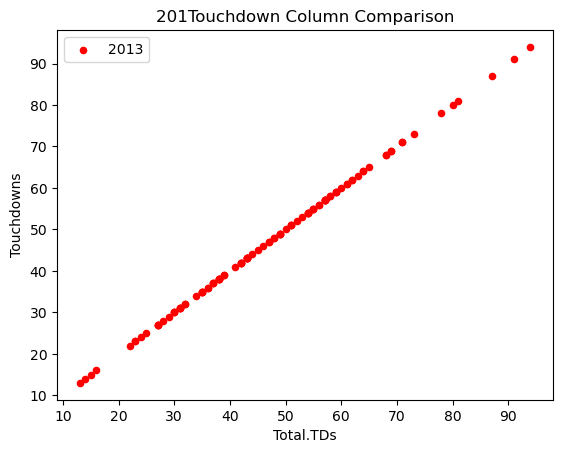

In [8]:
# Check if the Total.TDs and Touchdowns columns in df13 are duplicates
pandasDF13 = df13.toPandas()
ax = pandasDF13.plot(kind='scatter', x='Total.TDs', y='Touchdowns', color='Red', label='2013')

plt.title('201Touchdown Column Comparison')
plt.show()

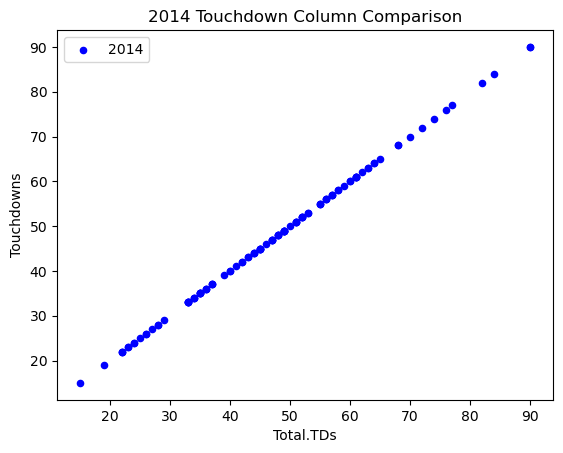

In [9]:
# Check if the Total.TDs and Touchdowns columns in df14 are duplicates
pandasDF14 = df14.toPandas()
ax = pandasDF14.plot(kind='scatter', x='Total.TDs', y='Touchdowns', color='Blue', label='2014')

plt.title('2014 Touchdown Column Comparison')
plt.show()

<br />
We repeat the same check for the 2015 data; however, we do not see the same linear trend suggesting these two values are not the same this year.
<br />
<br />

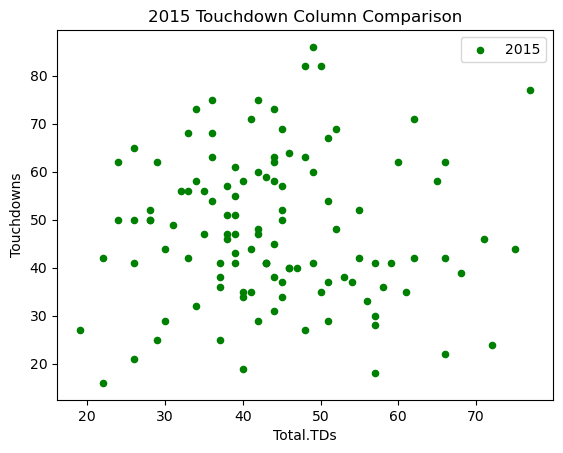

In [10]:
# Check if two columns in the 2015 data frame are equal
pandasDF15 = df15.toPandas()
pandasDF15.plot.scatter(x='Total.TDs',y='Touchdowns', color='Green', label='2015')

plt.title('2015 Touchdown Column Comparison')
plt.show()

<br />
<br />
We now investigate further to see if there are any trends in the touchdown-related columns for the year 2015. As shown below, something is not consistent with the 'Total.TDs' column since it is less than the number of offensive touchdowns. Since 'Total.TDs' and 'Touchdowns' are identical in 2013 and 2014 and there are discrepancies in 'Total.TDs' for 2015, we can justify removing that column from our data frame. This column does not appear in 2016 or later data sets.

<br />
<br />

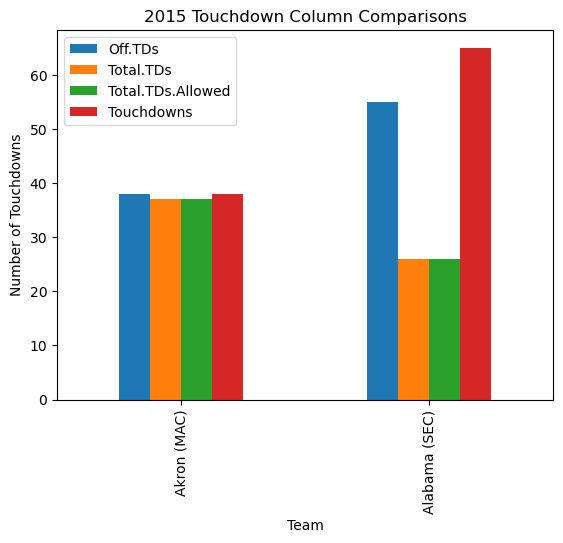

In [11]:
#Check a few of the touchdown columns in the 2015 data set to look for trends
pandasDF15.iloc[:2].plot(x="Team", y=["Off.TDs", "Total.TDs", "Total.TDs.Allowed", "Touchdowns"], kind="bar")
plt.title('2015 Touchdown Column Comparisons')
plt.ylabel("Number of Touchdowns")
plt.show()

<br />
<br />

Below we found the 146 common columns these data frames share. Each year has a different number of columns, so we found the 146 common ones and dropped the features that were not consistent throughout. In the cells above, we justified our reason for dropping 'Total.TDs' from the 2013 - 2015 data. The remaining 7 columns we want to drop are subsets of other fields that are present in all data sets so we chose to drop these columns as well. Only columns that are present in all 2013 - 2020 data sets will be kept.

<br />
<br />

The plot above suggests that 'Total.TDs' may be identical to 'Total.TDs.Allowed' rather than 'Touchdowns' like we expected. Below, we check if those two columns are identical across all schools rather than just Akron and Alabama. As we can see in the plot below, these two columns are identical. 

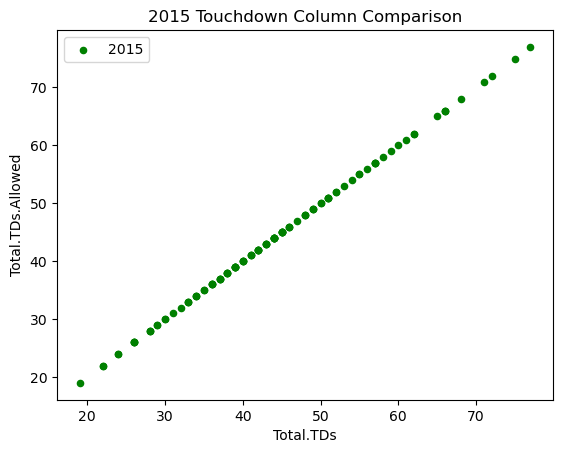

In [12]:
#Check if two columns in the 2015 data frame are equal
pandasDF15 = df15.toPandas()
pandasDF15.plot.scatter(x='Total.TDs',y='Total.TDs.Allowed', color='Green', label='2015')

plt.title('2015 Touchdown Column Comparison')
plt.show()

We investigated the columns that appear in 2013-2015 but not 2016-2020. Next, we investigate the 7 columns in 2016-2020 but not 2013-2015.

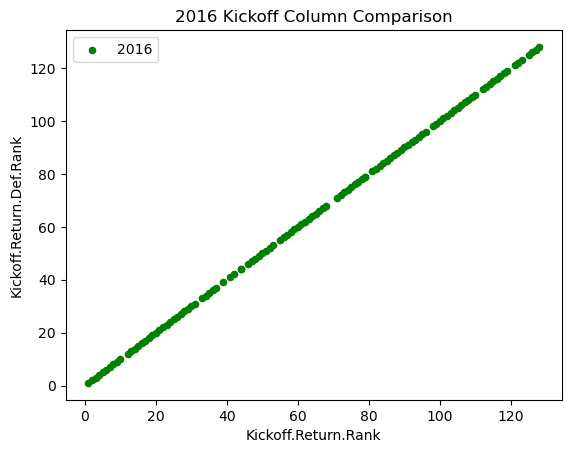

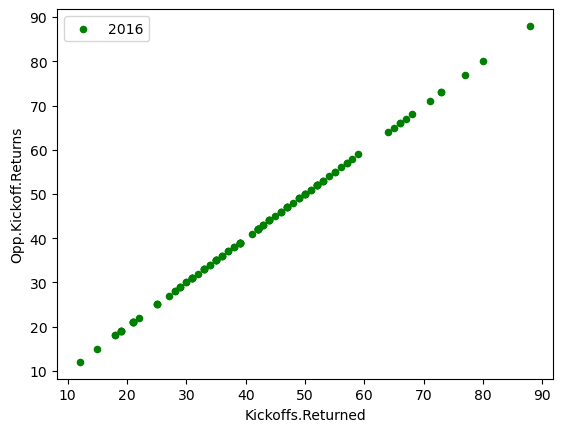

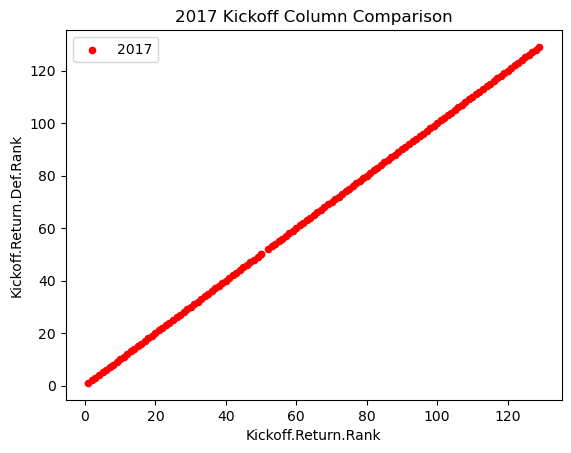

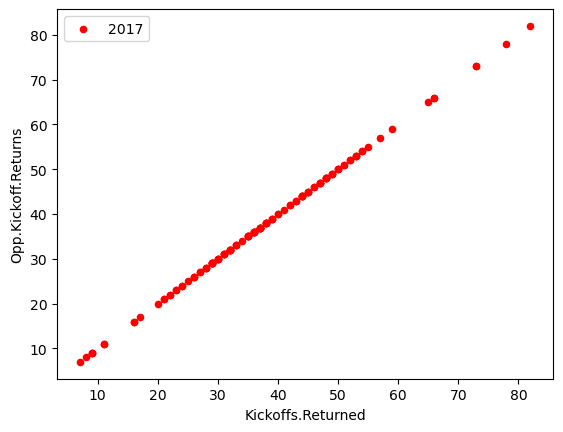

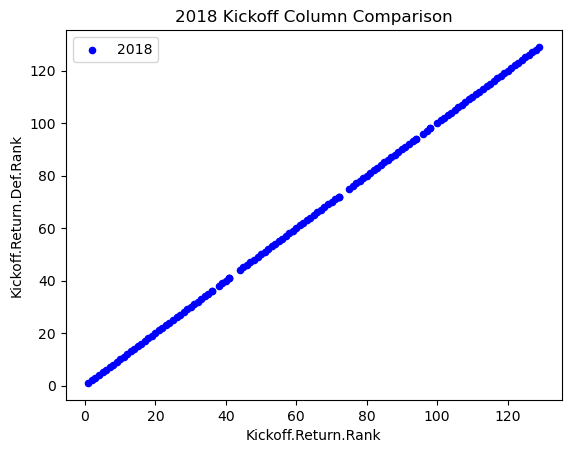

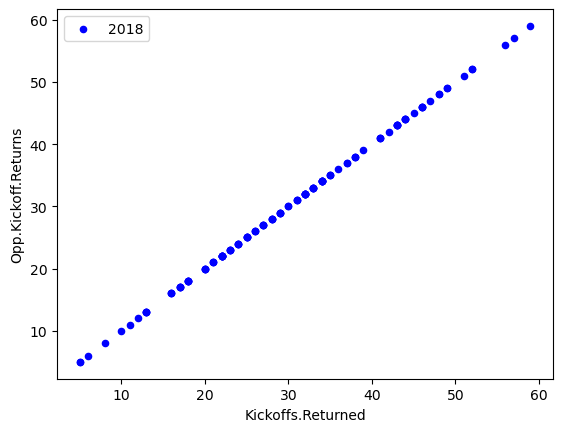

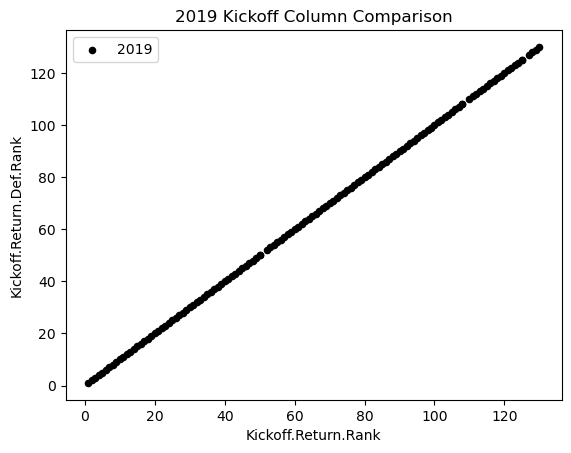

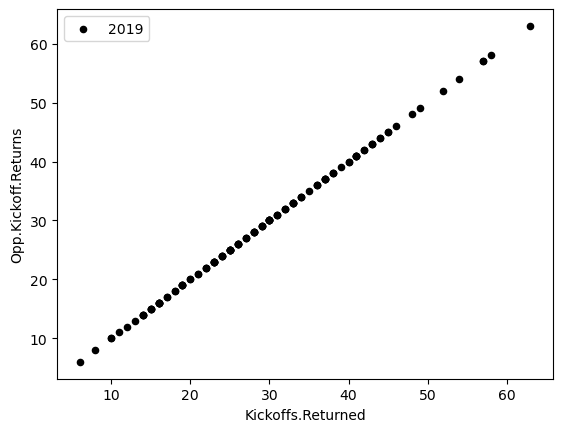

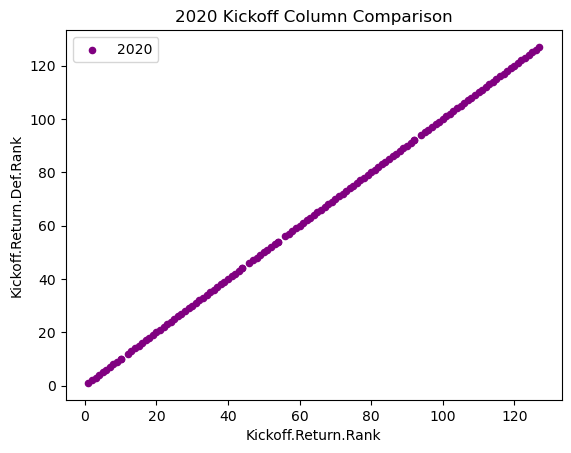

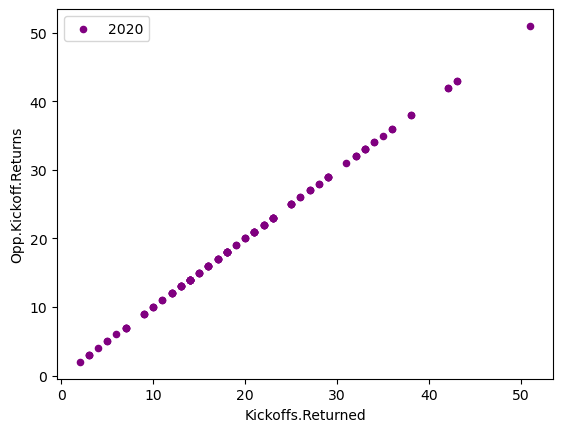

In [13]:
#Check if two columns in the 2016 dataframe are equal
pandasDF16 = df16.toPandas()
pandasDF16.plot.scatter(x='Kickoff.Return.Rank',y='Kickoff.Return.Def.Rank', color='Green', label='2016')
plt.title('2016 Kickoff Column Comparison')
pandasDF16.plot.scatter(x='Kickoffs.Returned',y='Opp.Kickoff.Returns', color='Green', label='2016')

#Check if two columns in the 2017 dataframe are equal
pandasDF17 = df17.toPandas()
pandasDF17.plot.scatter(x='Kickoff.Return.Rank',y='Kickoff.Return.Def.Rank', color='Red', label='2017')
plt.title('2017 Kickoff Column Comparison')
pandasDF17.plot.scatter(x='Kickoffs.Returned',y='Opp.Kickoff.Returns', color='Red', label='2017')

#Check if two columns in the 2016 dataframe are equal
pandasDF18 = df18.toPandas()
pandasDF18.plot.scatter(x='Kickoff.Return.Rank',y='Kickoff.Return.Def.Rank', color='Blue', label='2018')
plt.title('2018 Kickoff Column Comparison')
pandasDF18.plot.scatter(x='Kickoffs.Returned',y='Opp.Kickoff.Returns', color='Blue', label='2018')

#Check if two columns in the 2016 dataframe are equal
pandasDF19 = df19.toPandas()
pandasDF19.plot.scatter(x='Kickoff.Return.Rank',y='Kickoff.Return.Def.Rank', color='Black', label='2019')
plt.title('2019 Kickoff Column Comparison')
pandasDF19.plot.scatter(x='Kickoffs.Returned',y='Opp.Kickoff.Returns', color='Black', label='2019')

#Check if two columns in the 2016 dataframe are equal
pandasDF20 = df20.toPandas()
pandasDF20.plot.scatter(x='Kickoff.Return.Rank',y='Kickoff.Return.Def.Rank', color='Purple', label='2020')
plt.title('2020 Kickoff Column Comparison')
pandasDF20.plot.scatter(x='Kickoffs.Returned',y='Opp.Kickoff.Returns', color='Purple', label='2020')

plt.show()

We have shown above that the 'Kickoff.Return.Def.Rank' and 'Opp.Kickoff.Returns' columns are duplicates of the 'Kickoff.Return.Rank' and 'Kickoffs.Returned' columns, respectively. Thus, those two columns can be dropped from the 2016-2020 dataframes; however, we still need to check the other five columns. 

In [14]:
#Show the data for duplicate columns
df16.select("`Kickoff.Return.Yards`", "`Kickoff.Return.Touchdowns`", "`Avg.Yard.per.Kickoff.Return`", "`...40`", "`Kickoff.Touchbacks`", "`Opponent.Kickoff.Return.Yards`", "`Opp.Kickoff.Return.Touchdowns.Allowed`", "`Avg.Yards.per.Kickoff.Return.Allowed`").show()

+--------------------+-------------------------+---------------------------+-----+------------------+-----------------------------+-------------------------------------+------------------------------------+
|Kickoff.Return.Yards|Kickoff.Return.Touchdowns|Avg.Yard.per.Kickoff.Return|...40|Kickoff.Touchbacks|Opponent.Kickoff.Return.Yards|Opp.Kickoff.Return.Touchdowns.Allowed|Avg.Yards.per.Kickoff.Return.Allowed|
+--------------------+-------------------------+---------------------------+-----+------------------+-----------------------------+-------------------------------------+------------------------------------+
|                   8|                     1185|                          0|21.16|                 8|                         1185|                                    0|                               21.16|
|                  52|                     1212|                          0|21.26|                52|                         1212|                                    0|   

The values in the table above do not make sense based on our prior knowledge of football. Schools are not scoring 1185 kickoff return touchdowns. It appears there are duplicate columns in this table, but some of the column values were shifted from the appropriate column names as well. For example, the values for 'Kickoff.Return.Yards' appear in the 'Kickoff.Return.Touchdowns' column. For these particular columns, we need to shift the data values to the left one column or alternatively, shift the column headers to the right one column. It is clear that '...40', 'Kickoff.Touchbacks', 'Opponent.Kickoff.Return.Yards', 'Opp.Kickoff.Return.Touchdowns.Allowed', and 'Avg.Yards.per.Kickoff.Return.Allowed' contain duplicate columns already so we will drop these columns as well. 

In [15]:
#Shift the Kickoff.Return.Yards, Kickoff.Return.Touchdowns, and Avg.Yard.per.Kickoff.Return column headers to the right so the columns match the appropriate values
df16 = df16.drop("Kickoff.Return.Yards").withColumnRenamed("Kickoff.Return.Touchdowns","Kickoff.Return.Yards").withColumnRenamed("Avg.Yard.per.Kickoff.Return","Kickoff.Return.Touchdowns").withColumnRenamed("...40","Avg.Yard.per.Kickoff.Return")
df17 = df17.drop("Kickoff.Return.Yards").withColumnRenamed("Kickoff.Return.Touchdowns","Kickoff.Return.Yards").withColumnRenamed("Avg.Yard.per.Kickoff.Return","Kickoff.Return.Touchdowns").withColumnRenamed("...40","Avg.Yard.per.Kickoff.Return")
df18 = df18.drop("Kickoff.Return.Yards").withColumnRenamed("Kickoff.Return.Touchdowns","Kickoff.Return.Yards").withColumnRenamed("Avg.Yard.per.Kickoff.Return","Kickoff.Return.Touchdowns").withColumnRenamed("...40","Avg.Yard.per.Kickoff.Return")
df19 = df19.drop("Kickoff.Return.Yards").withColumnRenamed("Kickoff.Return.Touchdowns","Kickoff.Return.Yards").withColumnRenamed("Avg.Yard.per.Kickoff.Return","Kickoff.Return.Touchdowns").withColumnRenamed("...40","Avg.Yard.per.Kickoff.Return")
df20 = df20.drop("Kickoff.Return.Yards").withColumnRenamed("Kickoff.Return.Touchdowns","Kickoff.Return.Yards").withColumnRenamed("Avg.Yard.per.Kickoff.Return","Kickoff.Return.Touchdowns").withColumnRenamed("...40","Avg.Yard.per.Kickoff.Return")

#Show the transformed data to compare against the original table
df16.select("`Kickoff.Return.Yards`", "`Kickoff.Return.Touchdowns`", "`Avg.Yard.per.Kickoff.Return`", "`Kickoff.Touchbacks`", "`Opponent.Kickoff.Return.Yards`", "`Opp.Kickoff.Return.Touchdowns.Allowed`", "`Avg.Yards.per.Kickoff.Return.Allowed`").show()

+--------------------+-------------------------+---------------------------+------------------+-----------------------------+-------------------------------------+------------------------------------+
|Kickoff.Return.Yards|Kickoff.Return.Touchdowns|Avg.Yard.per.Kickoff.Return|Kickoff.Touchbacks|Opponent.Kickoff.Return.Yards|Opp.Kickoff.Return.Touchdowns.Allowed|Avg.Yards.per.Kickoff.Return.Allowed|
+--------------------+-------------------------+---------------------------+------------------+-----------------------------+-------------------------------------+------------------------------------+
|                1185|                        0|                      21.16|                 8|                         1185|                                    0|                               21.16|
|                1212|                        0|                      21.26|                52|                         1212|                                    0|                               21

<br />
<br />

Below we found the 146 common columns these dataframes share. Each year has a different number of columns, so we found the 146 common ones and dropped the features that were not consistent throughout. In the cells above, we justified our reasoning for only keeping columns that are present in all 2013 - 2020 dataframes.

<br />
<br />

In [16]:
# Check the number of columns that are the same in both a and b
target_columns = list(set(b) & set(a))

#print(target_columns)
print(len(target_columns))

146


In [17]:
# Drop the columns that don't appear in all csv files
df13 = df13.drop(*aNOTb)
df14 = df14.drop(*aNOTb)
df15 = df15.drop(*aNOTb)
df16 = df16.drop(*bNOTa)
df17 = df17.drop(*bNOTa)
df18 = df18.drop(*bNOTa)
df19 = df19.drop(*bNOTa)
df20 = df20.drop(*bNOTa)

In [18]:
# Union all data frames together
df = reduce(DataFrame.unionByName, [df13,df14,df15,df16,df17,df18,df19,df20])

# Check the new data frame
print("The data frame has",len(df.columns),"columns and",df.count(),"rows.")

The data frame has 146 columns and 970 rows.


In [19]:
# Drop duplicates
df=df.dropDuplicates()

# Check the new data frame
print("The data frame has",len(df.columns),"columns and",df.count(),"rows.")

The data frame has 146 columns and 970 rows.


In [20]:
# Check the schema for our combined data frame
df.printSchema()

root
 |-- Team: string (nullable = true)
 |-- Games: integer (nullable = true)
 |-- Win: integer (nullable = true)
 |-- Loss: integer (nullable = true)
 |-- Off.Rank: integer (nullable = true)
 |-- Off.Plays: integer (nullable = true)
 |-- Off.Yards: integer (nullable = true)
 |-- Off.Yards.Play: double (nullable = true)
 |-- Off.TDs: integer (nullable = true)
 |-- Off.Yards.per.Game: double (nullable = true)
 |-- Def.Rank: integer (nullable = true)
 |-- Def.Plays: integer (nullable = true)
 |-- Yards.Allowed: integer (nullable = true)
 |-- Yards.Play.Allowed: double (nullable = true)
 |-- Off.TDs.Allowed: integer (nullable = true)
 |-- Total.TDs.Allowed: integer (nullable = true)
 |-- Yards.Per.Game.Allowed: double (nullable = true)
 |-- First.Down.Rank: integer (nullable = true)
 |-- First.Down.Runs: integer (nullable = true)
 |-- First.Down.Passes: integer (nullable = true)
 |-- First.Down.Penalties: integer (nullable = true)
 |-- First.Downs: integer (nullable = true)
 |-- First.Do

In [21]:
#Columns we Do not want to Use

columns_to_drop = ['Time.of.Possession','Average.Time.of.Possession.per.Game']
df = df.drop(*columns_to_drop)

In [22]:
#Changing all . to _ in column names
df = df.toDF(*(c.replace('.', '_') for c in df.columns))

The boxplot below shows fairly consistent number of games played per year between 2013 and 2019. The year 2020 saw a much larger range of games played than previous years due to the COVID-19 pandemic.

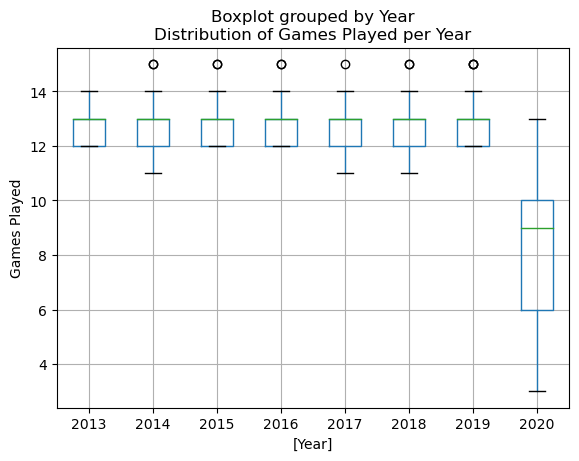

In [23]:
#Check the distribution of games played by year
pandasDF = df.toPandas()
pandasDF.boxplot(column=['Games'], by=['Year'])
plt.title('Distribution of Games Played per Year')
plt.ylabel("Games Played")
plt.show()

The boxplot above shows fairly consistent number of games played per year between 2013 and 2019. The year 2020 saw a much larger range of games played then previous years. This is likely a result of the COVID-19 pandemic which suggests we may need to consider whether that data should be included.

<br />
<br />

Next we will add columns for modeling. We want to predict the Bowl Eligibility of a Team. In order for a football team to advance to a Bowl, they must have a winning record (Wins > Losses). Therefore, we will create a category with 1 being a winning season and 0 being a tied or losing season.
<br />
<br />


In [24]:
df = df.withColumn(
    'WinningSeason',
    F.when((F.col("Win") > F.col("Loss")) , 1) \
    .otherwise(0))

df.show(2)

+----------------+-----+---+----+--------+---------+---------+--------------+-------+------------------+--------+---------+-------------+------------------+---------------+-----------------+----------------------+---------------+---------------+-----------------+--------------------+-----------+-------------------+-------------------+---------------------+------------------------+---------------+--------------+-------------+----------------+------------+------------------+------------------+---------------+--------------------+-------------------+-----------------+--------------------+-------------------------+---------------------------+----------------+-------------+----------------+----------------------+----------+------------------+----------------+---------------+-------------------+-------------+-----------------------+-----------------+--------------------+--------------------+---------------------+------------------------+---------------------------+------------+---------+----

In [25]:
df.dtypes

[('Team', 'string'),
 ('Games', 'int'),
 ('Win', 'int'),
 ('Loss', 'int'),
 ('Off_Rank', 'int'),
 ('Off_Plays', 'int'),
 ('Off_Yards', 'int'),
 ('Off_Yards_Play', 'double'),
 ('Off_TDs', 'int'),
 ('Off_Yards_per_Game', 'double'),
 ('Def_Rank', 'int'),
 ('Def_Plays', 'int'),
 ('Yards_Allowed', 'int'),
 ('Yards_Play_Allowed', 'double'),
 ('Off_TDs_Allowed', 'int'),
 ('Total_TDs_Allowed', 'int'),
 ('Yards_Per_Game_Allowed', 'double'),
 ('First_Down_Rank', 'int'),
 ('First_Down_Runs', 'int'),
 ('First_Down_Passes', 'int'),
 ('First_Down_Penalties', 'int'),
 ('First_Downs', 'int'),
 ('First_Down_Def_Rank', 'int'),
 ('Opp_First_Down_Runs', 'int'),
 ('Opp_First_Down_Passes', 'int'),
 ('Opp_First_Down_Penalties', 'int'),
 ('Opp_First_Downs', 'int'),
 ('X4th_Down_Rank', 'int'),
 ('X4th_Attempts', 'int'),
 ('X4th_Conversions', 'int'),
 ('X4th_Percent', 'double'),
 ('X4rd_Down_Def_Rank', 'int'),
 ('Opp_4th_Conversion', 'int'),
 ('Opp_4th_Attempt', 'int'),
 ('Opponent_4th_Percent', 'double'),
 ('K

In [26]:
df = df.cache()
pandasDF = df.toPandas()
pandasDF.head(5)

,Team,Games,Win,Loss,Off_Rank,Off_Plays,Off_Yards,Off_Yards_Play,Off_TDs,Off_Yards_per_Game,...,Fumbles_Recovered,Opponents_Intercepted,Turnovers_Gain,Fumbles_Lost,Interceptions_Thrown_y,Turnovers_Lost,Turnover_Margin,Avg_Turnover_Margin_per_Game,Year,WinningSeason
0,FIU (C-USA),13,6,7,91,877,4902,5.59,37,377.1,...,6,12,18,9,6,15,3,0.23,2019,0
1,Miami (FL) (ACC),10,8,2,36,725,4326,5.97,40,432.6,...,9,7,16,4,6,10,6,0.60,2020,1
2,Fla. Atlantic (C-USA),12,3,9,101,808,4357,5.39,32,363.1,...,7,8,15,13,5,18,-3,-0.25,2014,0
3,Akron (MAC),14,7,7,121,906,4424,4.88,38,316.0,...,8,19,27,6,11,17,10,0.71,2017,0
4,Georgia St. (Sun Belt),13,7,6,31,981,5718,5.83,52,439.8,...,8,9,17,7,9,16,1,0.08,2019,1


In [27]:
print("Response Variable Summary: \n\n")
df.groupby("WinningSeason").count().show()

Response Variable Summary: 


+-------------+-----+
|WinningSeason|count|
+-------------+-----+
|            1|  526|
|            0|  444|
+-------------+-----+



---
---

# EDA 

**Exploratory Data Analysis**

In [28]:
print("Win Variable Summary: \n\n")
df.select("Win").summary("count", "min", "25%", "75%", "max").show()

Win Variable Summary: 


+-------+---+
|summary|Win|
+-------+---+
|  count|970|
|    min|  0|
|    25%|  4|
|    75%|  9|
|    max| 15|
+-------+---+



In [29]:
#print("Table Summary: \n\n")
#df.summary("count", "min", "25%", "75%", "max").show()

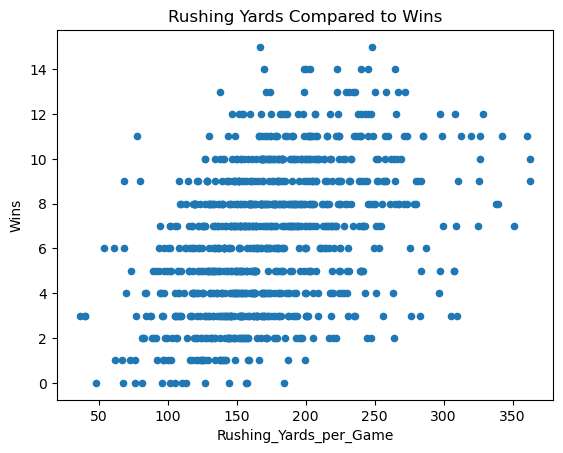

In [30]:
# Graph - Ruhsing yards compared to wins 

pandasDF.plot(x="Rushing_Yards_per_Game", y=["Win"], kind="scatter")
plt.title('Rushing Yards Compared to Wins')
plt.ylabel("Wins")
plt.show()

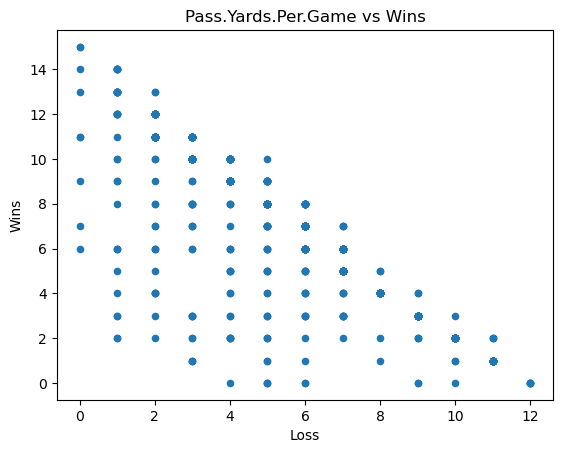

In [31]:
# Graph - Passing yards compared to wins 

pandasDF.plot(x="Loss", y=["Win"], kind="scatter")
plt.title('Pass.Yards.Per.Game vs Wins')
plt.ylabel("Wins")
plt.show()

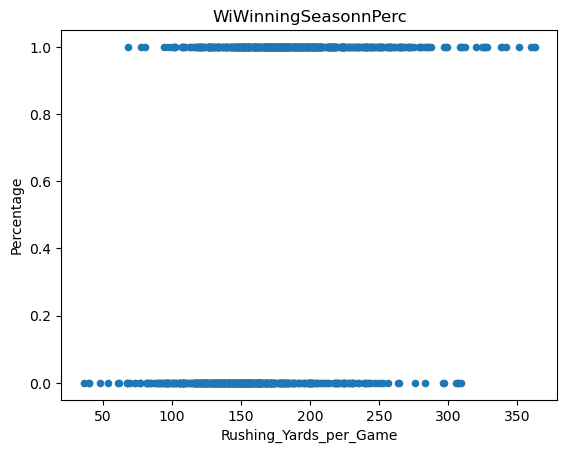

In [32]:
pandasDF.plot(x='Rushing_Yards_per_Game', y=["WinningSeason"], kind="scatter")
plt.title('WiWinningSeasonnPerc')
plt.ylabel("Percentage")
plt.show()

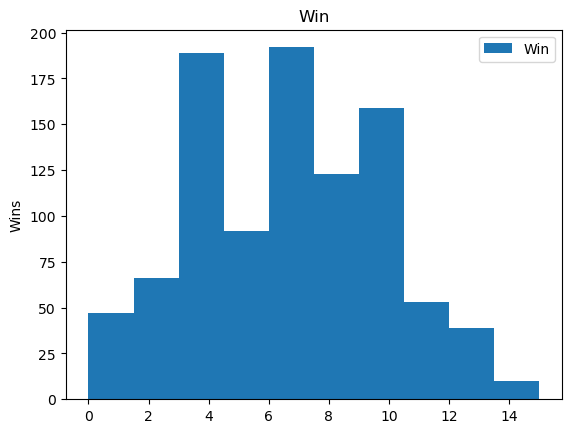

In [33]:
pandasDF.plot(x='Games', y=["Win"], kind="hist")
plt.title('Win')
plt.ylabel("Wins")
plt.show()

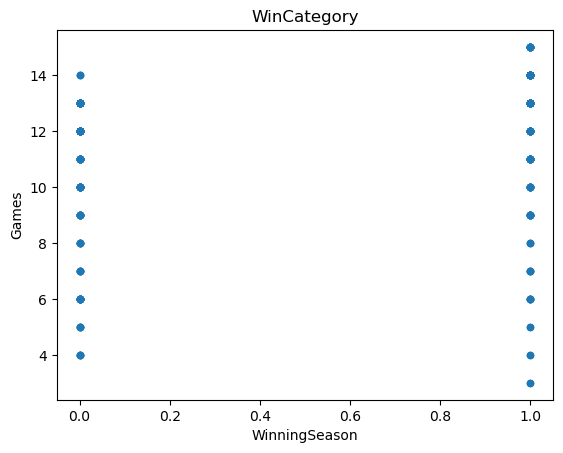

In [34]:
pandasDF.plot(x = 'WinningSeason', y = ['Games'], kind="scatter")
plt.title('WinCategory')
plt.ylabel("Games")
plt.show()

---
---

# Modeling

### Vector Assembler

In [35]:
required_features = df.columns[4:-1]

assembler = VectorAssembler(inputCols=required_features, outputCol='features')

tr = assembler.transform(df)

### Scale Data with StandardScalar

In [36]:
scaler = StandardScaler(inputCol="features", outputCol="scaledfeatures")

scalerModel = scaler.fit(tr)
scaledData = scalerModel.transform(tr)

scaledData.select("Win", "Loss", "WinningSeason", "scaledfeatures").show(2)

+---+----+-------------+--------------------+
|Win|Loss|WinningSeason|      scaledfeatures|
+---+----+-------------+--------------------+
|  6|   7|            0|[2.45454358812016...|
|  8|   2|            1|[0.97102823266292...|
+---+----+-------------+--------------------+
only showing top 2 rows



### Feature Selection: UnivariateFeatureSelector

"UnivariateFeatureSelector operates on categorical/continuous labels with
categorical/continuous features. User can set featureType and labelType,
and Spark will pick the score function to use based on the specified featureType and labelType."

<br />

In [37]:
selector = UnivariateFeatureSelector(featuresCol="scaledfeatures",
                                     outputCol="selectedFeatures",
                                     labelCol="WinningSeason",
                                     selectionMode="numTopFeatures")

selector.setFeatureType("continuous").setLabelType("categorical").setSelectionThreshold(20)

result = selector.fit(scaledData).transform(scaledData)

print("UnivariateFeatureSelector output with top %d features selected"
      % selector.getSelectionThreshold())
result.select("Win", "Loss", "WinningSeason", "selectedFeatures").show(2, truncate = False)

UnivariateFeatureSelector output with top 20 features selected
+---+----+-------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Win|Loss|WinningSeason|selectedFeatures                                                                                                                                                                                                                                                                                                                                                                 |
+---+----+-------------+---------------------------------------------------------------------------------------------------------------------------

In [38]:
result = result.cache()

### Split Train/Test Data

**Data Splitting/Sampling**

In [39]:
(train_data, test_data) = result.randomSplit([0.75,0.25], seed = 314)

In [40]:
(train_data.count(), test_data.count(), result.count())

(714, 256, 970)

# Building Models

**Model Construction, with at Least 3 Models**

<br />
<br />

### Variables and Evaluators for our Models

In [41]:
label = 'WinningSeason'


evaluator = MulticlassClassificationEvaluator(
    labelCol = label, 
    predictionCol = 'prediction', 
    metricName = 'accuracy')

ROC = BinaryClassificationEvaluator(
    rawPredictionCol="prediction",
    labelCol= label,
    metricName="areaUnderROC")

precision = MulticlassClassificationEvaluator(
    labelCol = label, 
    predictionCol = 'prediction', 
    metricName = 'precisionByLabel')

recall = MulticlassClassificationEvaluator(
    labelCol = label, 
    predictionCol = 'prediction', 
    metricName = 'recallByLabel')

fMeasure = MulticlassClassificationEvaluator(
    labelCol = label, 
    predictionCol = 'prediction', 
    metricName = 'f1')

tpr = MulticlassClassificationEvaluator(
    labelCol = label, 
    predictionCol = 'prediction', 
    metricName = 'truePositiveRateByLabel')

fpr = MulticlassClassificationEvaluator(
    labelCol = label, 
    predictionCol = 'prediction', 
    metricName = 'falsePositiveRateByLabel')

# Logistic Regression

In [42]:
log = LogisticRegression(labelCol = label,
                         featuresCol = 'selectedFeatures',
                         maxIter=5,
                         regParam=0.3,
                         elasticNetParam=0.8
                         )

log_model = log.fit(train_data)

In [43]:
log_pred = log_model.transform(train_data)

In [44]:
accuracy = evaluator.evaluate(log_pred)
print('Train Accuracy = ', accuracy)

Train Accuracy =  0.634453781512605


In [45]:
log_testpred = log_model.transform(test_data)

In [46]:
accuracy = evaluator.evaluate(log_testpred)
print('Test Accuracy = ', accuracy)

Test Accuracy =  0.6953125


In [47]:
### Evaluation Metrics
evaluate_model = log_testpred

accuracy = evaluator.evaluate(evaluate_model)
print('Test Accuracy = ', accuracy)

# pass to evaluator the DF with predictions, labels
aupr = ROC.evaluate(evaluate_model)
print("Area under PR Curve:", aupr)


# pass to evaluator the DF with predictions, labels
prec = precision.evaluate(evaluate_model)
print("Precision:", prec)


# pass to evaluator the DF with predictions, labels
#recall = recall.evaluate(evaluate_model)
#print("Recall:", recall)


# pass to evaluator the DF with predictions, labels
f1 = fMeasure.evaluate(evaluate_model)
print("F1 Measure:", f1)


# pass to evaluator the DF with predictions, labels
TPR = tpr.evaluate(evaluate_model)
print("True Positive Rate (Sensitivity):", TPR)


# pass to evaluator the DF with predictions, labels
FPR = fpr.evaluate(evaluate_model)
print("False Positive Rate :", FPR)

Test Accuracy =  0.6953125
Area under PR Curve: 0.6355140186915889
Precision: 1.0
F1 Measure: 0.6395421034105131
True Positive Rate (Sensitivity): 0.27102803738317754
False Positive Rate : 0.0


# Random Forest

In [48]:
rf = RandomForestClassifier(labelCol = label, 
                            featuresCol = 'selectedFeatures',
                            maxDepth = 5,
                            seed = 314)

rf_model = rf.fit(train_data)

In [49]:
rf_pred = rf_model.transform(train_data)

In [50]:
accuracy = evaluator.evaluate(rf_pred)
print('Train Accuracy = ', accuracy)

Train Accuracy =  0.9495798319327731


In [51]:
rf_testpred = rf_model.transform(test_data)

In [52]:
accuracy = evaluator.evaluate(rf_testpred)
print('Test Accuracy = ', accuracy)

Test Accuracy =  0.890625


In [53]:
### Evaluation Metrics
evaluate_model = rf_testpred

accuracy = evaluator.evaluate(evaluate_model)
print('Test Accuracy = ', accuracy)

# pass to evaluator the DF with predictions, labels
aupr = ROC.evaluate(evaluate_model)
print("Area under PR Curve:", aupr)


# pass to evaluator the DF with predictions, labels
prec = precision.evaluate(evaluate_model)
print("Precision:", prec)


# pass to evaluator the DF with predictions, labels
#recall = recall.evaluate(evaluate_model)
#print("Recall:", recall)


# pass to evaluator the DF with predictions, labels
f1 = fMeasure.evaluate(evaluate_model)
print("F1 Measure:", f1)


# pass to evaluator the DF with predictions, labels
TPR = tpr.evaluate(evaluate_model)
print("True Positive Rate (Sensitivity):", TPR)


# pass to evaluator the DF with predictions, labels
FPR = fpr.evaluate(evaluate_model)
print("False Positive Rate :", FPR)

Test Accuracy =  0.890625
Area under PR Curve: 0.8875995734805243
Precision: 0.8691588785046729
F1 Measure: 0.890625
True Positive Rate (Sensitivity): 0.8691588785046729
False Positive Rate : 0.09395973154362416


# Decision Tree

In [54]:
dt = DecisionTreeClassifier(labelCol = label,
                            featuresCol = 'selectedFeatures',
                            maxDepth = 3,
                            seed = 314)


dt_model = dt.fit(train_data)

In [55]:
dt_pred = dt_model.transform(train_data)

In [56]:
accuracy = evaluator.evaluate(dt_pred)
print('Train Accuracy = ', accuracy)

Train Accuracy =  0.8837535014005602


In [57]:
dt_testpred = dt_model.transform(test_data)

In [58]:
accuracy = evaluator.evaluate(dt_testpred)
print('Test Accuracy = ', accuracy)

Test Accuracy =  0.84765625


In [59]:
### Evaluation Metrics
evaluate_model = dt_testpred

accuracy = evaluator.evaluate(evaluate_model)
print('Test Accuracy = ', accuracy)

# pass to evaluator the DF with predictions, labels
aupr = ROC.evaluate(evaluate_model)
print("Area under PR Curve:", aupr)


# pass to evaluator the DF with predictions, labels
prec = precision.evaluate(evaluate_model)
print("Precision:", prec)


# pass to evaluator the DF with predictions, labels
#recall = recall.evaluate(evaluate_model)
#print("Recall:", recall)


# pass to evaluator the DF with predictions, labels
f1 = fMeasure.evaluate(evaluate_model)
print("F1 Measure:", f1)


# pass to evaluator the DF with predictions, labels
TPR = tpr.evaluate(evaluate_model)
print("True Positive Rate (Sensitivity):", TPR)


# pass to evaluator the DF with predictions, labels
FPR = fpr.evaluate(evaluate_model)
print("False Positive Rate :", FPR)

Test Accuracy =  0.84765625
Area under PR Curve: 0.8441008593112964
Precision: 0.8148148148148148
F1 Measure: 0.8477540668311017
True Positive Rate (Sensitivity): 0.822429906542056
False Positive Rate : 0.1342281879194631


# GBT

In [60]:
gbt = GBTClassifier(labelCol = label,
                    featuresCol = 'selectedFeatures',
                    maxIter = 5,
                    seed = 314)

gbt_model = gbt.fit(train_data)

In [61]:
gbt_pred = gbt_model.transform(train_data)

In [62]:
accuracy = evaluator.evaluate(gbt_pred)
print('Train Accuracy = ', accuracy)

Train Accuracy =  0.9649859943977591


In [63]:
gbt_testpred = gbt_model.transform(test_data)

In [64]:
accuracy = evaluator.evaluate(gbt_testpred)
print('Test Accuracy = ', accuracy)

Test Accuracy =  0.84765625


In [65]:
### Evaluation Metrics
evaluate_model = gbt_testpred

accuracy = evaluator.evaluate(evaluate_model)
print('Test Accuracy = ', accuracy)

# pass to evaluator the DF with predictions, labels
aupr = ROC.evaluate(evaluate_model)
print("Area under PR Curve:", aupr)


# pass to evaluator the DF with predictions, labels
prec = precision.evaluate(evaluate_model)
print("Precision:", prec)


# pass to evaluator the DF with predictions, labels
#recall = recall.evaluate(evaluate_model)
#print("Recall:", recall)


# pass to evaluator the DF with predictions, labels
f1 = fMeasure.evaluate(evaluate_model)
print("F1 Measure:", f1)


# pass to evaluator the DF with predictions, labels
TPR = tpr.evaluate(evaluate_model)
print("True Positive Rate (Sensitivity):", TPR)


# pass to evaluator the DF with predictions, labels
FPR = fpr.evaluate(evaluate_model)
print("False Positive Rate :", FPR)

Test Accuracy =  0.84765625
Area under PR Curve: 0.8361977043216458
Precision: 0.8541666666666666
F1 Measure: 0.8462403301210005
True Positive Rate (Sensitivity): 0.7663551401869159
False Positive Rate : 0.09395973154362416


# Fine Tuning

Overall, the best model without fine tuning or any extra work or testing was the random forest with an accuracy of 84.62% on the training data and 72% on the test data.
<br />
Moving forward, we will be using this model and fine tuning to see if the results can be improved.

<br />
Create CV Evaluator for Both Models

In [66]:
# Define an evaluation metric.  The CrossValidator compares the true labels with predicted values for each combination of parameters, and calculates this value to determine the best model.
cv_evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol=gbt.getLabelCol(),
    predictionCol=gbt.getPredictionCol()
)

### RF Model Fine Tuning

In [67]:
paramGrid = ParamGridBuilder()\
  .addGrid(rf.maxDepth, [0, 10])\
  .addGrid(rf.numTrees, [1, 10])\
  .build()

rf_cv = CrossValidator(estimator = rf, 
                    evaluator = cv_evaluator,
                    estimatorParamMaps = paramGrid,
                    numFolds = 5,
                    parallelism = 4,
                    seed = 314)



rf_model = rf_cv.fit(train_data)

In [68]:
rfpred = rf_model.transform(train_data)

In [69]:
accuracy = evaluator.evaluate(rfpred)
print('Train Accuracy = ', accuracy)

Train Accuracy =  0.9943977591036415


In [70]:
test_rfpred = rf_model.transform(test_data)

In [71]:
accuracy = evaluator.evaluate(test_rfpred)
print('Test Accuracy = ', accuracy)

Test Accuracy =  0.87109375


<br />
<br />

**Model Evaluation**

### Create Confusion Matrix

In [72]:
#important: need to cast to float type, and order by prediction, else it won't work
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

preds_and_labels = test_rfpred.select(['prediction','WinningSeason']).withColumn('label', F.col('WinningSeason').cast(FloatType())).orderBy('prediction')

#select only prediction and label columns
preds_and_labels = preds_and_labels.select(['prediction','label'])

metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

print(metrics.confusionMatrix().toArray())

[[ 96.  11.]
 [ 22. 127.]]


### Measures for Fine Tuned RF Model

In [73]:
# pass to evaluator the DF with predictions, labels
aupr = ROC.evaluate(test_rfpred)
print("Area under PR Curve:", aupr)


# pass to evaluator the DF with predictions, labels
prec = precision.evaluate(test_rfpred)
print("Precision:", prec)


# pass to evaluator the DF with predictions, labels
recall = recall.evaluate(test_rfpred)
print("Recall:", recall)


# pass to evaluator the DF with predictions, labels
f1 = fMeasure.evaluate(test_rfpred)
print("F1 Measure:", f1)


# pass to evaluator the DF with predictions, labels
TPR = tpr.evaluate(test_rfpred)
print("True Positive Rate (Sensitivity):", TPR)


# pass to evaluator the DF with predictions, labels
FPR = fpr.evaluate(test_rfpred)
print("False Positive Rate :", FPR)

Area under PR Curve: 0.8747726274854167
Precision: 0.8135593220338984
Recall: 0.897196261682243
F1 Measure: 0.8717744628339139
True Positive Rate (Sensitivity): 0.897196261682243
False Positive Rate : 0.1476510067114094


In [74]:
#Create WinPerc Column to see how close they were to a winning season
test_rfpred = test_rfpred.withColumn(
    'WinPerc',
    (test_rfpred.Win / test_rfpred.Games) * 100)

test_rfpred = test_rfpred.select("*", round("WinPerc",2))
test_rfpred = test_rfpred.withColumnRenamed("round(WinPerc, 2)" , "WinningPercentage")

+---------------+-----+---+----+--------+---------+---------+--------------+-------+------------------+--------+---------+-------------+------------------+---------------+-----------------+----------------------+---------------+---------------+-----------------+--------------------+-----------+-------------------+-------------------+---------------------+------------------------+---------------+--------------+-------------+----------------+------------+------------------+------------------+---------------+--------------------+-------------------+-----------------+--------------------+-------------------------+---------------------------+----------------+-------------+----------------+----------------------+----------+------------------+----------------+---------------+-------------------+-------------+-----------------------+-----------------+--------------------+--------------------+---------------------+------------------------+---------------------------+------------+---------+-----

In [85]:
test_rfpred.select("WinningPercentage", "WinningSeason",
                   "prediction", "probability"
                  ).show()

+-----------------+-------------+----------+-----------+
|WinningPercentage|WinningSeason|prediction|probability|
+-----------------+-------------+----------+-----------+
|            41.67|            0|       0.0|  [0.7,0.3]|
|            69.23|            1|       1.0|  [0.0,1.0]|
|            84.62|            1|       1.0|  [0.0,1.0]|
|            53.85|            1|       1.0|  [0.3,0.7]|
|            44.44|            0|       1.0|  [0.1,0.9]|
|            69.23|            1|       1.0|  [0.0,1.0]|
|            28.57|            0|       0.0|  [0.7,0.3]|
|            61.54|            1|       1.0|  [0.1,0.9]|
|            53.85|            1|       1.0|  [0.0,1.0]|
|            18.18|            0|       0.0|  [1.0,0.0]|
|            41.67|            0|       0.0|  [0.8,0.2]|
|            41.67|            0|       0.0|  [0.6,0.4]|
|            77.78|            1|       1.0|  [0.0,1.0]|
|            46.15|            0|       1.0|  [0.0,1.0]|
|            61.54|            

In [84]:
test_rfpred.select("WinningPercentage", "WinningSeason", "prediction", "probability",
                   "Off_Rank", "Off_Plays", "Off_Yards", "Off_Yards_Play",
                   "Off_TDs", "Off_Yards_per_Game", "Def_Rank", "Yards_Play_Allowed",
                   "Off_TDs_Allowed", "Total_TDs_Allowed", "Yards_Per_Game_Allowed","Opp_4th_Attempt",
                   "Kickoffs_Returned", "Kickoff_Return_Yards", "Pass_Yards","Pass_Yards_Attempt",
                   "Yards_Completion", "Pass_Touchdowns", "Opp_Pass_Attempts", "Yards_Attempt_Allowed"
                  ).show()

+-----------------+-------------+----------+-----------+--------+---------+---------+--------------+-------+------------------+--------+------------------+---------------+-----------------+----------------------+---------------+-----------------+--------------------+----------+------------------+----------------+---------------+-----------------+---------------------+
|WinningPercentage|WinningSeason|prediction|probability|Off_Rank|Off_Plays|Off_Yards|Off_Yards_Play|Off_TDs|Off_Yards_per_Game|Def_Rank|Yards_Play_Allowed|Off_TDs_Allowed|Total_TDs_Allowed|Yards_Per_Game_Allowed|Opp_4th_Attempt|Kickoffs_Returned|Kickoff_Return_Yards|Pass_Yards|Pass_Yards_Attempt|Yards_Completion|Pass_Touchdowns|Opp_Pass_Attempts|Yards_Attempt_Allowed|
+-----------------+-------------+----------+-----------+--------+---------+---------+--------------+-------+------------------+--------+------------------+---------------+-----------------+----------------------+---------------+-----------------+------------